# Classification of age groups using functional connectivity

## Extracting signal from fMRI volumes

```{figure} images/masking.jpg
---
height: 450px
name: masking
---
Masking fMRI data.
```

Essentially, we can think about overlaying a 3D grid on an image.
Then, our mask tells us which cubes or “voxels” (like 3D pixels) to sample from.
Since our Nifti images are 4D files, we can’t overlay a single grid –
instead, we use a series of 3D grids (one for each volume in the 4D file),
so we can get a measurement for each voxel at each timepoint.
These are reflected in the shape of the matrix !
You can check this by checking the number of positive voxels in our brain mask.

## An example classification problem

This example compares different kinds of functional connectivity between
regions of interest: correlation, partial correlation, and tangent space
embedding.

The resulting connectivity coefficients can be used to
discriminate children from adults. In general, the tangent space embedding
**outperforms** the standard correlations: see {cite}`Dadi_2019`
for a careful study.

## Load brain development fMRI dataset and MSDL atlas

We study only 30 subjects from the dataset, to save computation time.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn import input_data
from nilearn import datasets

development_dataset = datasets.fetch_development_fmri(n_subjects=30)


Dataset created in /home/runner/nilearn_data/development_fmri


Dataset created in /home/runner/nilearn_data/development_fmri/development_fmri



Downloaded 16041 of 16041 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68285 of 68285 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5642698 of 5642698 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67851 of 67851 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 4946416 of 4946416 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 69170 of 69170 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 5875966 of 5875966 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68464 of 68464 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5845425 of 5845425 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68189 of 68189 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6522229 of 6522229 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 69463 of 69463 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6139107 of 6139107 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68468 of 68468 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6293165 of 6293165 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68130 of 68130 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6136523 of 6136523 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68340 of 68340 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5837641 of 5837641 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 71331 of 71331 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6118892 of 6118892 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68533 of 68533 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6453693 of 6453693 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68590 of 68590 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6176491 of 6176491 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68630 of 68630 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6225801 of 6225801 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68331 of 68331 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6232787 of 6232787 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68425 of 68425 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 7361169 of 7361169 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68894 of 68894 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6586819 of 6586819 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68848 of 68848 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6111716 of 6111716 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68243 of 68243 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6067448 of 6067448 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 69265 of 69265 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6122113 of 6122113 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68479 of 68479 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6295931 of 6295931 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68301 of 68301 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6384587 of 6384587 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 67912 of 67912 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5934622 of 5934622 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68499 of 68499 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6316470 of 6316470 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67733 of 67733 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6020576 of 6020576 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68275 of 68275 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6551822 of 6551822 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68896 of 68896 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6116459 of 6116459 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68182 of 68182 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6752586 of 6752586 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68403 of 68403 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6023997 of 6023997 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68534 of 68534 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6312316 of 6312316 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 69162 of 69162 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6031594 of 6031594 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


We use probabilistic regions of interest (ROIs) from the MSDL atlas.

In [2]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))


Dataset created in /home/runner/nilearn_data/msdl_atlas



MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


Downloaded 209734 of 209734 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/runner/nilearn_data/msdl_atlas/5d25e157f36214b8ca9a12fd417aac1c/MSDL_rois.zip..... done.
/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


## Region signals extraction

To extract regions time series, we instantiate a
:class:`nilearn.input_data.NiftiMapsMasker` object and pass the atlas the
file name to it, as well as filtering band-width and detrending option.

In [3]:
masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1).fit()

Then we compute region signals and extract useful phenotypic informations.

In [4]:
children = []
pooled_subjects = []
groups = []  # child or adult
for func_file, confound_file, phenotypic in zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    if phenotypic['Child_Adult'] == 'child':
        children.append(time_series)
    groups.append(phenotypic['Child_Adult'])

print('Data has {0} children.'.format(len(children)))

Data has 24 children.


## ROI-to-ROI correlations of children

The simpler and most commonly used kind of connectivity is correlation. It
models the full (marginal) connectivity between pairwise ROIs. We can
estimate it using :class:`nilearn.connectome.ConnectivityMeasure`.

In [5]:
correlation_measure = ConnectivityMeasure(kind='correlation')

From the list of ROIs time-series for children, the
`correlation_measure` computes individual correlation matrices.

In [6]:
correlation_matrices = correlation_measure.fit_transform(children)

All individual coefficients are stacked in a unique 2D matrix.

In [7]:
print('Correlations of children are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

Correlations of children are stacked in an array of shape (24, 39, 39)


as well as the average correlation across all fitted subjects.

In [8]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (39, 39).


We display the connectome matrices of the first 3 children

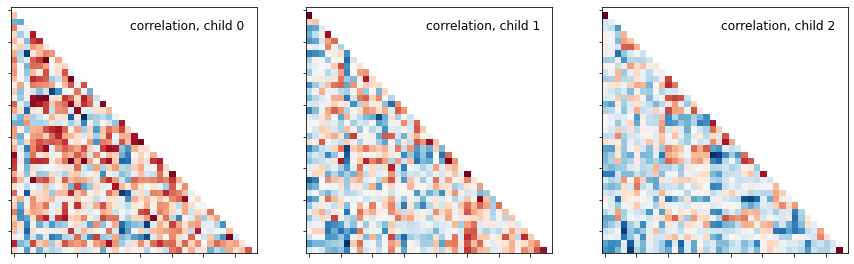

In [9]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='correlation, child {}'.format(i))

The blocks structure that reflect functional networks are visible.

Now we display as a connectome the mean correlation matrix over all children.

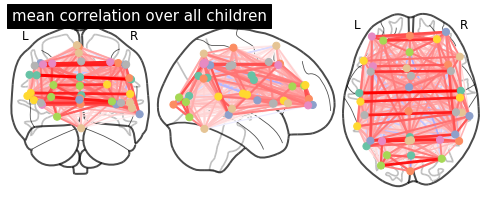

In [10]:
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         title='mean correlation over all children')

## Studying partial correlations

We can also study **direct connections**, revealed by partial correlation
coefficients. We just change the `ConnectivityMeasure` kind

In [11]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrices = partial_correlation_measure.fit_transform(
    children)

Most of direct connections are weaker than full connections.

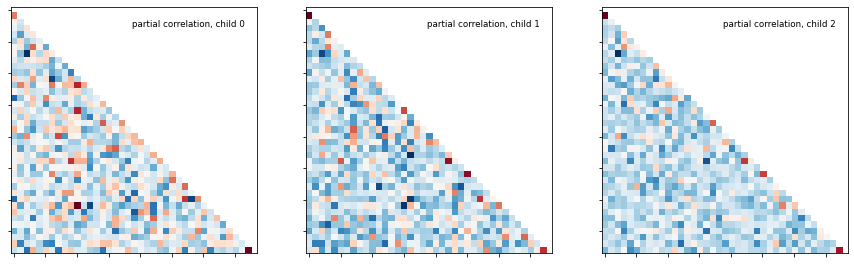

In [12]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(partial_correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='partial correlation, child {}'.format(i))

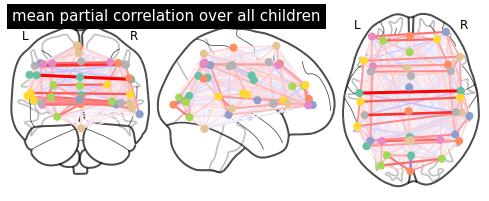

In [13]:
plotting.plot_connectome(
    partial_correlation_measure.mean_, msdl_coords,
    title='mean partial correlation over all children')

## Extract subjects variabilities around a group connectivity

We can use **both** correlations and partial correlations to capture
reproducible connectivity patterns at the group-level.
This is done by the tangent space embedding.

In [14]:
tangent_measure = ConnectivityMeasure(kind='tangent')

We fit our children group and get the group connectivity matrix stored as
in `tangent_measure.mean_`, and individual deviation matrices of each subject
from it.

In [15]:
tangent_matrices = tangent_measure.fit_transform(children)

`tangent_matrices` model individual connectivities as
**perturbations** of the group connectivity matrix `tangent_measure.mean_`.
Keep in mind that these subjects-to-group variability matrices do not
directly reflect individual brain connections. For instance negative
coefficients can not be interpreted as anticorrelated regions.

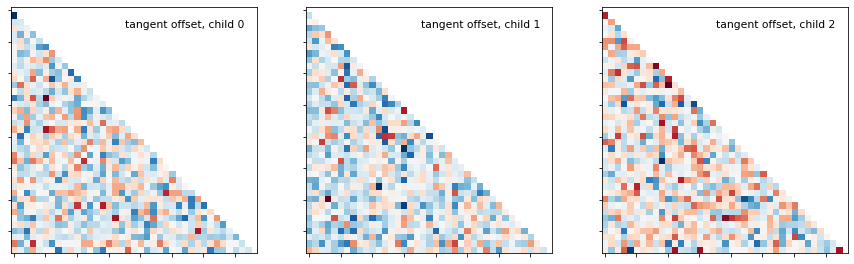

In [16]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(tangent_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='tangent offset, child {}'.format(i))

The average tangent matrix cannot be interpreted, as individual matrices
represent deviations from the mean, which is set to 0.

## What kind of connectivity is most powerful for classification?

We will use connectivity matrices as features to distinguish children from
adults. We use cross-validation and measure classification accuracy to
compare the different kinds of connectivity matrices.
We use random splits of the subjects into training/testing sets.
StratifiedShuffleSplit allows preserving the proportion of children in the
test set.

In [17]:
kinds = ['correlation', 'partial correlation', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

display the results

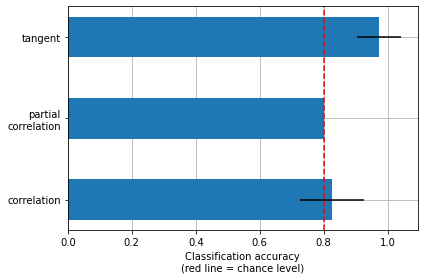

In [18]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()

This is a small example to showcase nilearn features. In practice such
comparisons need to be performed on much larger cohorts and several
datasets.
{cite}`Dadi_2019` showed that across many cohorts and clinical questions,
the tangent kind should be preferred.

```{bibliography} references.bib
:style: unsrt
```